# Promethee I

Iniciando o cálculo de probabilidades e custos esperados...
  Equipamento 100/500 processado.
  Equipamento 200/500 processado.
  Equipamento 300/500 processado.
  Equipamento 400/500 processado.
  Equipamento 500/500 processado.
Cálculo de probabilidades concluído.
Executando PROMETHEE I para seleção de planos de manutenção...
  Equipamento 100/500 - plano escolhido: M3
    Matriz de preferência:
[[0.         0.5        1.        ]
 [0.47295373 0.         0.5       ]
 [1.11940484 0.64645111 0.        ]]
    Fluxo de saída: [0.5        0.32431791 0.58861865]
    Fluxo de entrada: [0.53078619 0.38215037 0.5       ]
    Fluxo líquido: [-0.03078619 -0.05783246  0.08861865]
  Equipamento 200/500 - plano escolhido: M1
    Matriz de preferência:
[[0.         0.5        1.        ]
 [0.40919306 0.         0.5       ]
 [0.90092604 0.49173298 0.        ]]
    Fluxo de saída: [0.5        0.30306435 0.46421968]
    Fluxo de entrada: [0.43670637 0.33057766 0.5       ]
    Fluxo líquido: [ 0.063293

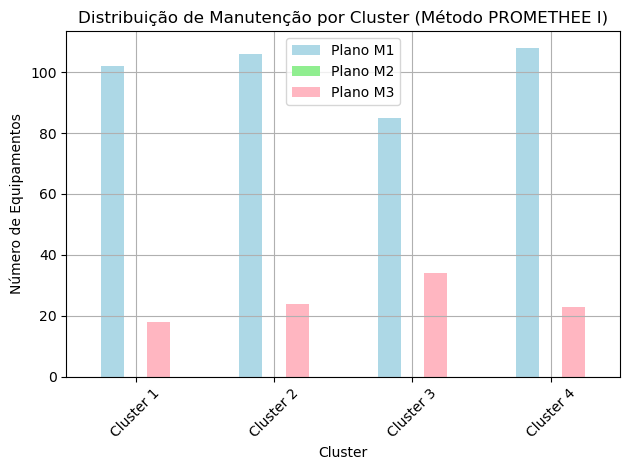

Execução finalizada.


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# caminhos dos arquivos extraídos
caminho_base = "arquivos_tc/"
tabela_equipamentos = pd.read_csv(caminho_base + "EquipDB.csv", header=None)
tabela_clusters = pd.read_csv(caminho_base + "ClusterDB.csv", header=None)
tabela_planos = pd.read_csv(caminho_base + "MPDB.csv", header=None)

# quantidade de equipamentos e planos de manutencao
num_equipamentos = tabela_equipamentos.shape[0]
num_planos = 3  # M1, M2, M3

# nomes e cores para visualização
NOMES_CLUSTERS = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]
CORES_PLANOS = ["lightblue", "lightgreen", "lightpink"]
np.random.seed(203)

# função de distribuição acumulada de Weibull
def distribuicao_weibull(tempo, eta, beta):
    return 1 - np.exp(-(tempo / eta) ** beta)

# inicializa matrizes para probabilidades de falha p_ij e custos esperados f2_ij
matriz_prob_falha = np.zeros((num_equipamentos, num_planos))
matriz_custo_esperado = np.zeros((num_equipamentos, num_planos))
custo_falha = tabela_equipamentos.iloc[:, 3]
tempo_delta = 5

print("Iniciando o cálculo de probabilidades e custos esperados...")

for i in range(num_equipamentos):
    tempo_operacao = tabela_equipamentos.iloc[i, 1]
    cluster_id = tabela_equipamentos.iloc[i, 2]
    eta, beta = tabela_clusters.loc[tabela_clusters[0] == cluster_id].iloc[0, 1:3]

    for j in range(num_planos):
        fator_risco = tabela_planos.iloc[j, 1]
        numerador = distribuicao_weibull(tempo_operacao + fator_risco * tempo_delta, eta, beta) - distribuicao_weibull(tempo_operacao, eta, beta)
        denominador = 1 - distribuicao_weibull(tempo_operacao, eta, beta)
        probabilidade = numerador / denominador
        matriz_prob_falha[i, j] = probabilidade
        matriz_custo_esperado[i, j] = probabilidade * custo_falha.iloc[i]

    if (i + 1) % 100 == 0 or (i + 1) == num_equipamentos:
        print(f"  Equipamento {i + 1}/{num_equipamentos} processado.")

print("Cálculo de probabilidades concluído.")

matriz_custo_plano = np.tile(np.array([0, 1, 2]), (num_equipamentos, 1))
matriz_custo_falha = matriz_custo_esperado.copy()

# cálculo da solução global para os pesos definidos
pesos_criterios = [0.5, 0.5]
planos_escolhidos = []

fluxos_saida_todos = []
fluxos_entrada_todos = []
fluxos_liquido_todos = []

print("Executando PROMETHEE I para seleção de planos de manutenção...")

def promethee_i(f1_vals, f2_vals, pesos):
    n = len(f1_vals)
    matriz_preferencia = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            preferencia_f1 = max(0, f1_vals[j] - f1_vals[i])
            preferencia_f2 = max(0, f2_vals[j] - f2_vals[i])
            matriz_preferencia[i, j] = pesos[0] * preferencia_f1 + pesos[1] * preferencia_f2

    fluxo_saida = np.mean(matriz_preferencia, axis=1)
    fluxo_entrada = np.mean(matriz_preferencia, axis=0)
    fluxo_liquido = fluxo_saida - fluxo_entrada
    return matriz_preferencia, fluxo_saida, fluxo_entrada, fluxo_liquido

for i in range(num_equipamentos):
    matriz_pref, f_saida, f_entrada, f_liquido = promethee_i(matriz_custo_plano[i], matriz_custo_falha[i], pesos_criterios)
    melhor_plano = np.argmax(f_liquido)
    planos_escolhidos.append(melhor_plano + 1)

    fluxos_saida_todos.append(f_saida)
    fluxos_entrada_todos.append(f_entrada)
    fluxos_liquido_todos.append(f_liquido)

    if (i + 1) % 100 == 0 or (i + 1) == num_equipamentos:
        print(f"  Equipamento {i + 1}/{num_equipamentos} - plano escolhido: M{melhor_plano + 1}")
        print(f"    Matriz de preferência:\n{matriz_pref}")
        print(f"    Fluxo de saída: {f_saida}")
        print(f"    Fluxo de entrada: {f_entrada}")
        print(f"    Fluxo líquido: {f_liquido}")

print("Seleção de planos concluída.")

resultado_final = pd.DataFrame()
resultado_final['Equipamento'] = tabela_equipamentos.iloc[:, 0]
resultado_final['Cluster'] = tabela_equipamentos.iloc[:, 2]
resultado_final['Plano_Manutencao'] = planos_escolhidos

f1_total = sum(matriz_custo_plano[i, plano - 1] for i, plano in enumerate(planos_escolhidos))
f2_total = sum(matriz_custo_falha[i, plano - 1] for i, plano in enumerate(planos_escolhidos))
print(f"\nResultado global PROMETHEE I com pesos {pesos_criterios} => f1_total = {f1_total:.2f}, f2_total = {f2_total:.2f}\n")

frequencia = pd.crosstab(resultado_final['Cluster'], resultado_final['Plano_Manutencao'])
frequencia = frequencia.reindex(index=range(1, 5), columns=range(1, 4), fill_value=0)
frequencia.columns = ["M1", "M2", "M3"]

print("Gerando gráfico de distribuição final...")

frequencia.plot(kind='bar', stacked=False, color=CORES_PLANOS)
plt.title("Distribuição de Manutenção por Cluster (Método PROMETHEE I)")
plt.xlabel("Cluster")
plt.ylabel("Número de Equipamentos")
plt.xticks(ticks=range(4), labels=NOMES_CLUSTERS, rotation=45)
plt.legend([f"Plano M{j+1}" for j in range(num_planos)])
plt.grid(True)
plt.tight_layout()
plt.show()

print("Execução finalizada.")


# Promethee II

Iniciando o cálculo de probabilidades e custos esperados...
  Equipamento 100/500 processado.
  Equipamento 200/500 processado.
  Equipamento 300/500 processado.
  Equipamento 400/500 processado.
  Equipamento 500/500 processado.
Cálculo de probabilidades concluído.
Executando PROMETHEE II para seleção de planos de manutenção...
  Equipamento 100/500 - plano escolhido: M3
    Fluxo de saída: [0.75       0.48647687 0.88292798]
    Fluxo de entrada: [0.79617929 0.57322555 0.75      ]
    Fluxo líquido: [-0.04617929 -0.08674869  0.13292798]
  Equipamento 200/500 - plano escolhido: M1
    Fluxo de saída: [0.75       0.45459653 0.69632951]
    Fluxo de entrada: [0.65505955 0.49586649 0.75      ]
    Fluxo líquido: [ 0.09494045 -0.04126996 -0.05367049]
  Equipamento 300/500 - plano escolhido: M1
    Fluxo de saída: [0.75       0.30724817 0.19913082]
    Fluxo de entrada: [0.18543767 0.32094132 0.75      ]
    Fluxo líquido: [ 0.56456233 -0.01369315 -0.55086918]
  Equipamento 400/500 - plano 

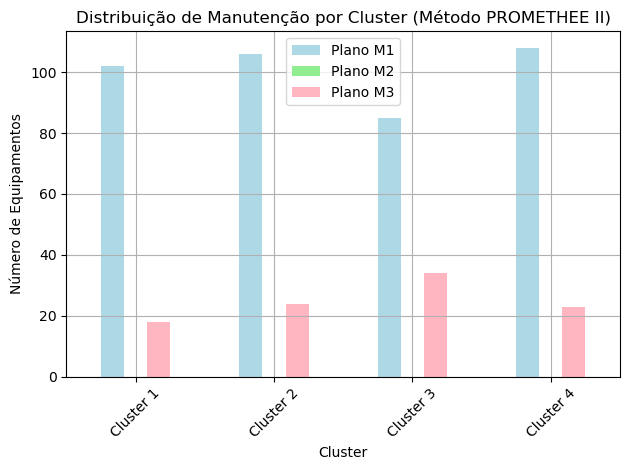

Execução finalizada.


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# caminhos dos arquivos extraídos
caminho_base = "arquivos_tc/"
tabela_equipamentos = pd.read_csv(caminho_base + "EquipDB.csv", header=None)
tabela_clusters = pd.read_csv(caminho_base + "ClusterDB.csv", header=None)
tabela_planos = pd.read_csv(caminho_base + "MPDB.csv", header=None)

# quantidade de equipamentos e planos de manutencao
num_equipamentos = tabela_equipamentos.shape[0]
num_planos = 3  # M1, M2, M3

# nomes e cores para visualização
NOMES_CLUSTERS = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]
CORES_PLANOS = ["lightblue", "lightgreen", "lightpink"]
np.random.seed(203)

# função de distribuição acumulada de Weibull
def distribuicao_weibull(tempo, eta, beta):
    return 1 - np.exp(-(tempo / eta) ** beta)

# inicializa matrizes para probabilidades de falha p_ij e custos esperados f2_ij
matriz_prob_falha = np.zeros((num_equipamentos, num_planos))
matriz_custo_esperado = np.zeros((num_equipamentos, num_planos))
custo_falha = tabela_equipamentos.iloc[:, 3]
tempo_delta = 5

print("Iniciando o cálculo de probabilidades e custos esperados...")

for i in range(num_equipamentos):
    tempo_operacao = tabela_equipamentos.iloc[i, 1]
    cluster_id = tabela_equipamentos.iloc[i, 2]
    eta, beta = tabela_clusters.loc[tabela_clusters[0] == cluster_id].iloc[0, 1:3]

    for j in range(num_planos):
        fator_risco = tabela_planos.iloc[j, 1]
        numerador = distribuicao_weibull(tempo_operacao + fator_risco * tempo_delta, eta, beta) - distribuicao_weibull(tempo_operacao, eta, beta)
        denominador = 1 - distribuicao_weibull(tempo_operacao, eta, beta)
        probabilidade = numerador / denominador
        matriz_prob_falha[i, j] = probabilidade
        matriz_custo_esperado[i, j] = probabilidade * custo_falha.iloc[i]

    if (i + 1) % 100 == 0 or (i + 1) == num_equipamentos:
        print(f"  Equipamento {i + 1}/{num_equipamentos} processado.")

print("Cálculo de probabilidades concluído.")

matriz_custo_plano = np.tile(np.array([0, 1, 2]), (num_equipamentos, 1))
matriz_custo_falha = matriz_custo_esperado.copy()

# cálculo da solução global para os pesos definidos
pesos_criterios = [0.5, 0.5]
planos_escolhidos = []

fluxos_saida_todos = []
fluxos_entrada_todos = []
fluxos_liquido_todos = []

print("Executando PROMETHEE II para seleção de planos de manutenção...")

def promethee_ii(f1_vals, f2_vals, pesos):
    n = len(f1_vals)
    matriz_preferencia = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            preferencia_f1 = max(0, f1_vals[j] - f1_vals[i])
            preferencia_f2 = max(0, f2_vals[j] - f2_vals[i])
            matriz_preferencia[i, j] = pesos[0] * preferencia_f1 + pesos[1] * preferencia_f2

    fluxo_saida = np.sum(matriz_preferencia, axis=1) / (n - 1)
    fluxo_entrada = np.sum(matriz_preferencia, axis=0) / (n - 1)
    fluxo_liquido = fluxo_saida - fluxo_entrada
    return fluxo_saida, fluxo_entrada, fluxo_liquido

for i in range(num_equipamentos):
    f_saida, f_entrada, f_liquido = promethee_ii(matriz_custo_plano[i], matriz_custo_falha[i], pesos_criterios)
    melhor_plano = np.argmax(f_liquido)
    planos_escolhidos.append(melhor_plano + 1)

    fluxos_saida_todos.append(f_saida)
    fluxos_entrada_todos.append(f_entrada)
    fluxos_liquido_todos.append(f_liquido)

    if (i + 1) % 100 == 0 or (i + 1) == num_equipamentos:
        print(f"  Equipamento {i + 1}/{num_equipamentos} - plano escolhido: M{melhor_plano + 1}")
        print(f"    Fluxo de saída: {f_saida}")
        print(f"    Fluxo de entrada: {f_entrada}")
        print(f"    Fluxo líquido: {f_liquido}")

print("Seleção de planos concluída.")

resultado_final = pd.DataFrame()
resultado_final['Equipamento'] = tabela_equipamentos.iloc[:, 0]
resultado_final['Cluster'] = tabela_equipamentos.iloc[:, 2]
resultado_final['Plano_Manutencao'] = planos_escolhidos

f1_total = sum(matriz_custo_plano[i, plano - 1] for i, plano in enumerate(planos_escolhidos))
f2_total = sum(matriz_custo_falha[i, plano - 1] for i, plano in enumerate(planos_escolhidos))
print(f"\nResultado global PROMETHEE II com pesos {pesos_criterios} => f1_total = {f1_total:.2f}, f2_total = {f2_total:.2f}\n")

frequencia = pd.crosstab(resultado_final['Cluster'], resultado_final['Plano_Manutencao'])
frequencia = frequencia.reindex(index=range(1, 5), columns=range(1, 4), fill_value=0)
frequencia.columns = ["M1", "M2", "M3"]

print("Gerando gráfico de distribuição final...")

frequencia.plot(kind='bar', stacked=False, color=CORES_PLANOS)
plt.title("Distribuição de Manutenção por Cluster (Método PROMETHEE II)")
plt.xlabel("Cluster")
plt.ylabel("Número de Equipamentos")
plt.xticks(ticks=range(4), labels=NOMES_CLUSTERS, rotation=45)
plt.legend([f"Plano M{j+1}" for j in range(num_planos)])
plt.grid(True)
plt.tight_layout()
plt.show()

print("Execução finalizada.")


# Electre IS com limiares de concordância (c_thresh) e discordância (d_thresh) variados, bem como pesos de cada critério

Iniciando o cálculo de probabilidades e custos esperados...
  Equipamento 100/500 processado.
  Equipamento 200/500 processado.
  Equipamento 300/500 processado.
  Equipamento 400/500 processado.
  Equipamento 500/500 processado.
Cálculo de probabilidades concluído.
Executando ELECTRE IS para vários pesos e limiares...


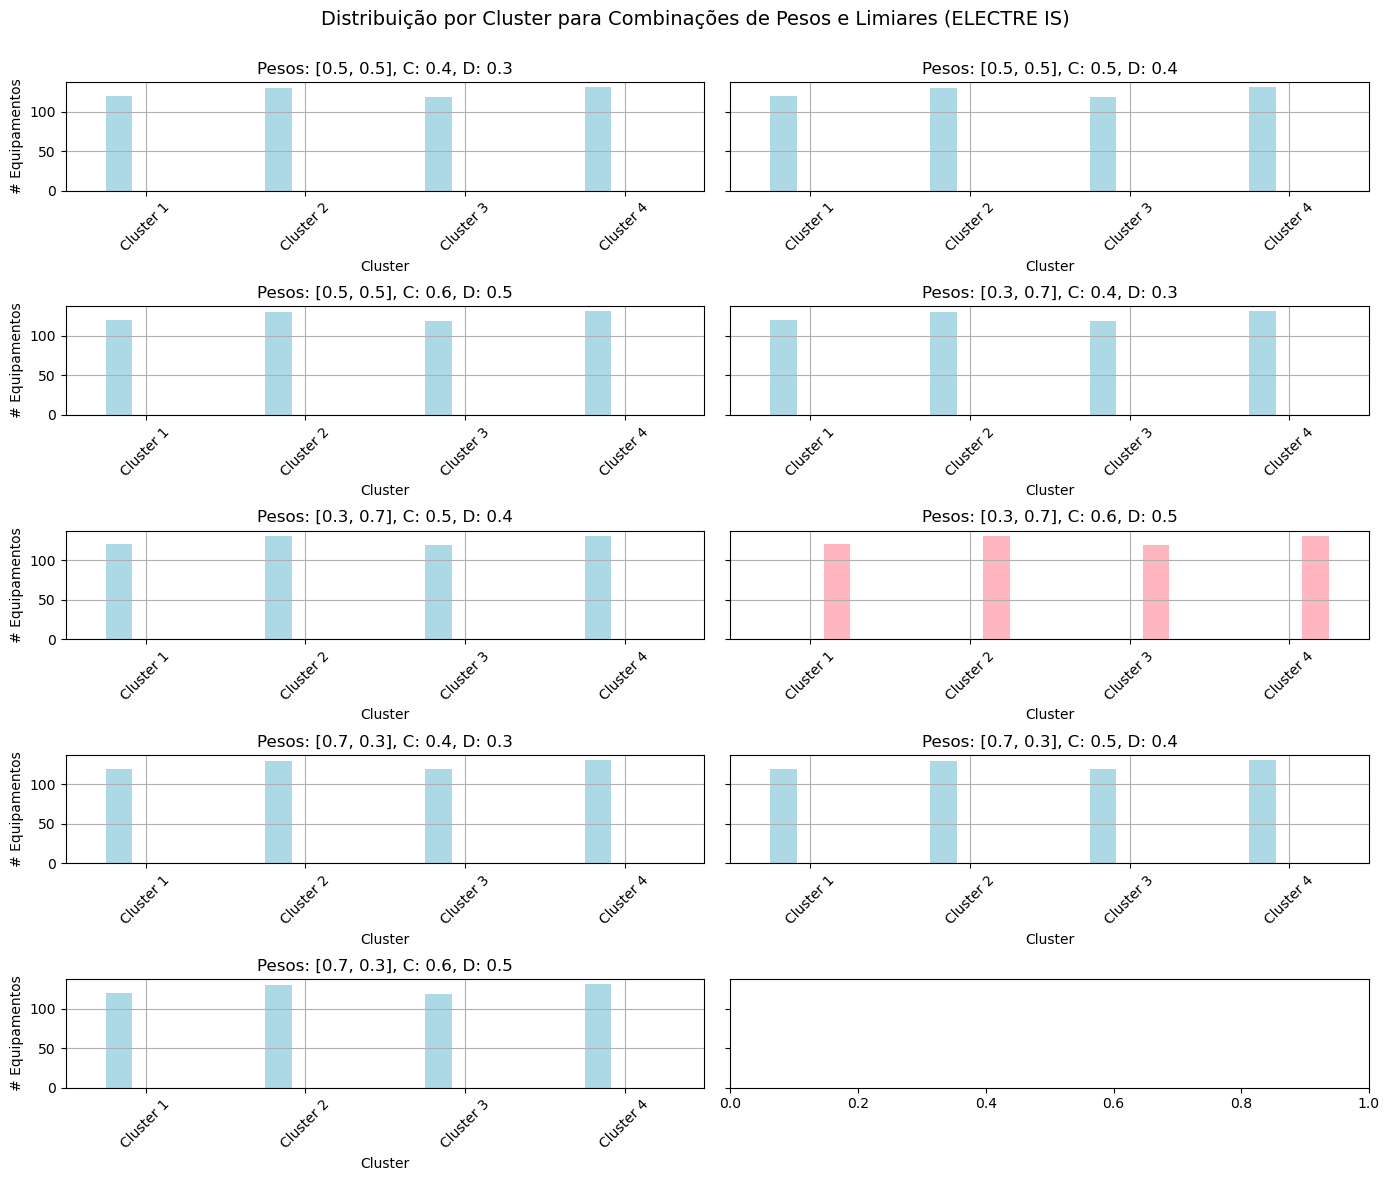

Testes múltiplos finalizados.


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# caminhos dos arquivos extraídos
caminho_base = "arquivos_tc/"
tabela_equipamentos = pd.read_csv(caminho_base + "EquipDB.csv", header=None)
tabela_clusters = pd.read_csv(caminho_base + "ClusterDB.csv", header=None)
tabela_planos = pd.read_csv(caminho_base + "MPDB.csv", header=None)

# quantidade de equipamentos e planos de manutencao
num_equipamentos = tabela_equipamentos.shape[0]
num_planos = 3  # M1, M2, M3

# nomes e cores para visualização
NOMES_CLUSTERS = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]
CORES_PLANOS = ["lightblue", "lightgreen", "lightpink"]
np.random.seed(203)

# função de distribuição acumulada de Weibull
def distribuicao_weibull(tempo, eta, beta):
    return 1 - np.exp(-(tempo / eta) ** beta)

# inicializa matrizes para probabilidades de falha p_ij e custos esperados f2_ij
matriz_prob_falha = np.zeros((num_equipamentos, num_planos))
matriz_custo_esperado = np.zeros((num_equipamentos, num_planos))
custo_falha = tabela_equipamentos.iloc[:, 3]
tempo_delta = 5

print("Iniciando o cálculo de probabilidades e custos esperados...")

for i in range(num_equipamentos):
    tempo_operacao = tabela_equipamentos.iloc[i, 1]
    cluster_id = tabela_equipamentos.iloc[i, 2]
    eta, beta = tabela_clusters.loc[tabela_clusters[0] == cluster_id].iloc[0, 1:3]

    for j in range(num_planos):
        fator_risco = tabela_planos.iloc[j, 1]
        numerador = distribuicao_weibull(tempo_operacao + fator_risco * tempo_delta, eta, beta) - distribuicao_weibull(tempo_operacao, eta, beta)
        denominador = 1 - distribuicao_weibull(tempo_operacao, eta, beta)
        probabilidade = numerador / denominador
        matriz_prob_falha[i, j] = probabilidade
        matriz_custo_esperado[i, j] = probabilidade * custo_falha.iloc[i]

    if (i + 1) % 100 == 0 or (i + 1) == num_equipamentos:
        print(f"  Equipamento {i + 1}/{num_equipamentos} processado.")

print("Cálculo de probabilidades concluído.")

matriz_custo_plano = np.tile(np.array([0, 1, 2]), (num_equipamentos, 1))
matriz_custo_falha = matriz_custo_esperado.copy()

# parâmetros a testar
pesos_testes = [[0.5, 0.5], [0.3, 0.7], [0.7, 0.3]]
limiares_testes = [(0.4, 0.3), (0.5, 0.4), (0.6, 0.5)]

print("Executando ELECTRE IS para vários pesos e limiares...")

# função que executa o método ELECTRE IS
def electre_is(f1_vals, f2_vals, pesos, c_thresh, d_thresh):
    n = len(f1_vals)
    matriz_concordancia = np.zeros((n, n))
    matriz_discordancia = np.zeros((n, n))
    norm_f1 = (f1_vals - np.min(f1_vals)) / (np.max(f1_vals) - np.min(f1_vals) + 1e-6)
    norm_f2 = (f2_vals - np.min(f2_vals)) / (np.max(f2_vals) - np.min(f2_vals) + 1e-6)

    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            concordancia = 0
            discordancia = 0
            if norm_f1[i] <= norm_f1[j]:
                concordancia += pesos[0]
            else:
                discordancia = max(discordancia, abs(norm_f1[i] - norm_f1[j]))
            if norm_f2[i] <= norm_f2[j]:
                concordancia += pesos[1]
            else:
                discordancia = max(discordancia, abs(norm_f2[i] - norm_f2[j]))
            matriz_concordancia[i, j] = concordancia
            matriz_discordancia[i, j] = discordancia

    matriz_sobreposicao = (matriz_concordancia >= c_thresh) & (matriz_discordancia <= d_thresh)
    fluxo_saida = np.sum(matriz_sobreposicao, axis=1)
    fluxo_entrada = np.sum(matriz_sobreposicao, axis=0)
    fluxo_liquido = fluxo_saida - fluxo_entrada

    return fluxo_saida, fluxo_entrada, fluxo_liquido

# gera gráficos com 2 colunas por linha
fig, axs = plt.subplots(nrows=(len(pesos_testes) * len(limiares_testes) + 1) // 2, ncols=2, figsize=(14, 12), sharey=True)
axs = axs.flatten()

idx_plot = 0
for i, pesos in enumerate(pesos_testes):
    for j, (c_thresh, d_thresh) in enumerate(limiares_testes):
        planos_escolhidos = []
        for k in range(num_equipamentos):
            fluxo_saida, fluxo_entrada, fluxo_liquido = electre_is(matriz_custo_plano[k], matriz_custo_falha[k], pesos, c_thresh, d_thresh)
            melhor_plano = np.argmax(fluxo_liquido)
            planos_escolhidos.append(melhor_plano + 1)

        resultado_temp = pd.DataFrame()
        resultado_temp['Cluster'] = tabela_equipamentos.iloc[:, 2]
        resultado_temp['Plano_Manutencao'] = planos_escolhidos
        frequencia = pd.crosstab(resultado_temp['Cluster'], resultado_temp['Plano_Manutencao'])
        frequencia = frequencia.reindex(index=range(1, 5), columns=[1, 2, 3], fill_value=0)
        frequencia.columns = ["M1", "M2", "M3"]

        ax = axs[idx_plot]
        idx_plot += 1
        frequencia.plot(kind='bar', stacked=False, color=CORES_PLANOS, ax=ax, legend=False)
        ax.set_title(f"Pesos: {pesos}, C: {c_thresh}, D: {d_thresh}")
        ax.set_xlabel("Cluster")
        ax.set_ylabel("# Equipamentos")
        ax.set_xticks(range(4))
        ax.set_xticklabels(NOMES_CLUSTERS, rotation=45)
        ax.grid(True)

fig.suptitle("Distribuição por Cluster para Combinações de Pesos e Limiares (ELECTRE IS)", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

print("Testes múltiplos finalizados.")


# Electre III

Iniciando o cálculo de probabilidades e custos esperados...
  Equipamento 100/500 processado.
  Equipamento 200/500 processado.
  Equipamento 300/500 processado.
  Equipamento 400/500 processado.
  Equipamento 500/500 processado.
Cálculo de probabilidades concluído.
Executando ELECTRE III para vários pesos e limiares...


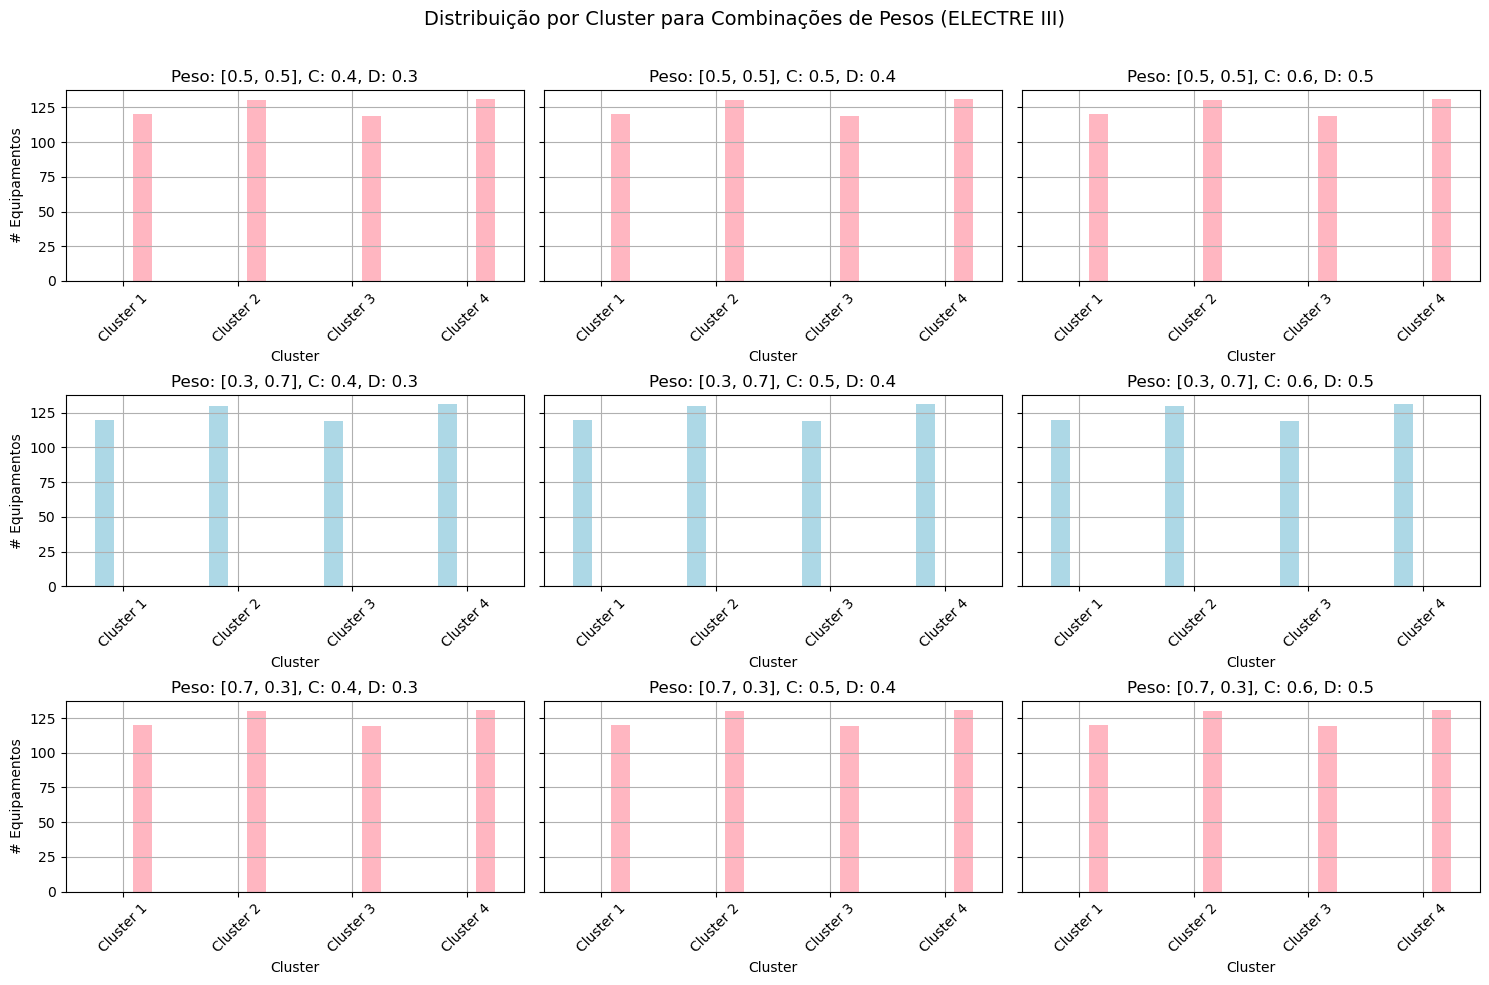

Testes múltiplos finalizados.


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# caminhos dos arquivos extraídos
caminho_base = "arquivos_tc/"
tabela_equipamentos = pd.read_csv(caminho_base + "EquipDB.csv", header=None)
tabela_clusters = pd.read_csv(caminho_base + "ClusterDB.csv", header=None)
tabela_planos = pd.read_csv(caminho_base + "MPDB.csv", header=None)

# quantidade de equipamentos e planos de manutencao
num_equipamentos = tabela_equipamentos.shape[0]
num_planos = 3  # M1, M2, M3

# nomes e cores para visualização
NOMES_CLUSTERS = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]
CORES_PLANOS = ["lightblue", "lightgreen", "lightpink"]
np.random.seed(203)

# função de distribuição acumulada de Weibull
def distribuicao_weibull(tempo, eta, beta):
    return 1 - np.exp(-(tempo / eta) ** beta)

# inicializa matrizes para probabilidades de falha p_ij e custos esperados f2_ij
matriz_prob_falha = np.zeros((num_equipamentos, num_planos))
matriz_custo_esperado = np.zeros((num_equipamentos, num_planos))
custo_falha = tabela_equipamentos.iloc[:, 3]
tempo_delta = 5

print("Iniciando o cálculo de probabilidades e custos esperados...")

for i in range(num_equipamentos):
    tempo_operacao = tabela_equipamentos.iloc[i, 1]
    cluster_id = tabela_equipamentos.iloc[i, 2]
    eta, beta = tabela_clusters.loc[tabela_clusters[0] == cluster_id].iloc[0, 1:3]

    for j in range(num_planos):
        fator_risco = tabela_planos.iloc[j, 1]
        numerador = distribuicao_weibull(tempo_operacao + fator_risco * tempo_delta, eta, beta) - distribuicao_weibull(tempo_operacao, eta, beta)
        denominador = 1 - distribuicao_weibull(tempo_operacao, eta, beta)
        probabilidade = numerador / denominador
        matriz_prob_falha[i, j] = probabilidade
        matriz_custo_esperado[i, j] = probabilidade * custo_falha.iloc[i]

    if (i + 1) % 100 == 0 or (i + 1) == num_equipamentos:
        print(f"  Equipamento {i + 1}/{num_equipamentos} processado.")

print("Cálculo de probabilidades concluído.")

matriz_custo_plano = np.tile(np.array([0, 1, 2]), (num_equipamentos, 1))
matriz_custo_falha = matriz_custo_esperado.copy()

print("Executando ELECTRE III para vários pesos e limiares...")

def electre_iii(f1_vals, f2_vals, pesos, q, p, v):
    n = len(f1_vals)
    matriz_concordancia = np.zeros((n, n))
    matriz_discordancia = np.zeros((n, n))
    
    norm_f1 = (f1_vals - np.min(f1_vals)) / (np.max(f1_vals) - np.min(f1_vals) + 1e-6)
    norm_f2 = (f2_vals - np.min(f2_vals)) / (np.max(f2_vals) - np.min(f2_vals) + 1e-6)

    for i in range(n):
        for j in range(n):
            if i == j:
                continue

            c1 = 0 if norm_f1[i] - norm_f1[j] <= q else (1 if norm_f1[j] - norm_f1[i] <= q else (norm_f1[j] - norm_f1[i] - q) / (p - q))
            c2 = 0 if norm_f2[i] - norm_f2[j] <= q else (1 if norm_f2[j] - norm_f2[i] <= q else (norm_f2[j] - norm_f2[i] - q) / (p - q))

            matriz_concordancia[i, j] = pesos[0] * c1 + pesos[1] * c2
            d1 = 0 if norm_f1[j] - norm_f1[i] <= p else (v - abs(norm_f1[i] - norm_f1[j])) / v
            d2 = 0 if norm_f2[j] - norm_f2[i] <= p else (v - abs(norm_f2[i] - norm_f2[j])) / v
            matriz_discordancia[i, j] = max(d1, d2)

    matriz_sobreposicao = (matriz_concordancia >= matriz_discordancia)
    fluxo_saida = np.sum(matriz_sobreposicao, axis=1)
    fluxo_entrada = np.sum(matriz_sobreposicao, axis=0)
    fluxo_liquido = fluxo_saida - fluxo_entrada
    return fluxo_liquido

# valores a testar
pesos_testes = [[0.5, 0.5], [0.3, 0.7], [0.7, 0.3]]
limiares_testes = [(0.4, 0.3), (0.5, 0.4), (0.6, 0.5)]

# plot para cada combinação
fig, axs = plt.subplots(len(pesos_testes), len(limiares_testes), figsize=(15, 10), sharey=True)

for i, pesos in enumerate(pesos_testes):
    for j, (c_thresh, d_thresh) in enumerate(limiares_testes):
        planos_escolhidos = []
        for k in range(num_equipamentos):
            fluxos = electre_iii(matriz_custo_plano[k], matriz_custo_falha[k], pesos, q=0.05, p=0.2, v=1.0)
            melhor_plano = np.argmax(fluxos)
            planos_escolhidos.append(melhor_plano + 1)

        resultado_temp = pd.DataFrame()
        resultado_temp['Cluster'] = tabela_equipamentos.iloc[:, 2]
        resultado_temp['Plano_Manutencao'] = planos_escolhidos
        frequencia = pd.crosstab(resultado_temp['Cluster'], resultado_temp['Plano_Manutencao'])
        frequencia = frequencia.reindex(index=range(1, 5), columns=[1, 2, 3], fill_value=0)
        frequencia.columns = ["M1", "M2", "M3"]

        ax = axs[i, j]
        frequencia.plot(kind='bar', stacked=False, color=CORES_PLANOS, ax=ax, legend=False)
        ax.set_title(f"Peso: {pesos}, C: {c_thresh}, D: {d_thresh}")
        ax.set_xlabel("Cluster")
        ax.set_ylabel("# Equipamentos")
        ax.set_xticks(range(4))
        ax.set_xticklabels(NOMES_CLUSTERS, rotation=45)
        ax.grid(True)

fig.suptitle("Distribuição por Cluster para Combinações de Pesos (ELECTRE III)", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

print("Testes múltiplos finalizados.")
